In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile
from keras.utils.np_utils import to_categorical
from tqdm import tqdm
from utils import wav2arr1s, which_set, BASE_TRAIN_FOLDER_SPEC, BASE_TRAIN_FOLDER_WAV, labels_to_ints

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, BatchNormalization, MaxPooling1D, Flatten
from keras.optimizers import SGD

### Load dataset
From compiled files. See wav-compile.ipynb

In [3]:
COMPILED_FOLDER = "compiled-wav"

In [4]:
x_train = np.load(os.path.join(COMPILED_FOLDER, f"x_train.npy"))
y_train = np.load(os.path.join(COMPILED_FOLDER, f"y_train.npy"))

In [5]:
x_val = np.load(os.path.join(COMPILED_FOLDER, f"x_validation.npy"))
y_val = np.load(os.path.join(COMPILED_FOLDER, f"y_validation.npy"))

In [6]:
x_test = np.load(os.path.join(COMPILED_FOLDER, f"x_testing.npy"))
y_test = np.load(os.path.join(COMPILED_FOLDER, f"y_testing.npy"))

In [7]:
x_train = np.reshape(x_train, (*x_train.shape, 1))
x_test = np.reshape(x_test, (*x_test.shape, 1))
x_val = np.reshape(x_val, (*x_val.shape, 1))

In [8]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((51490, 8000, 1),
 (51490, 31),
 (6798, 8000, 1),
 (6798, 31),
 (6835, 8000, 1),
 (6835, 31))

In [9]:
# Source : https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/discussion/44283#256644
model = Sequential()
for i in range(6): 
    model.add(Conv1D(8*(2 ** i), (3),padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D((2), padding='same'))

In [10]:
model.add(Dense(1024, activation = 'relu', name= 'dense1024'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(len(labels_to_ints), activation = 'softmax'))

In [11]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
h = model.fit(x_train, y_train,
          epochs=25,
          batch_size=128,
          validation_data=(x_val, y_val)
         )

Instructions for updating:
Use tf.cast instead.
Train on 51490 samples, validate on 6798 samples
Epoch 1/25
51490/51490 [==============================] - 1144s 22ms/step - loss: 2.3033 - acc: 0.3678 - val_loss: 12.6918 - val_acc: 0.0550
Epoch 2/25
51490/51490 [==============================] - 1102s 21ms/step - loss: 1.2736 - acc: 0.6524 - val_loss: 13.7624 - val_acc: 0.0508
Epoch 3/25
51490/51490 [==============================] - 1124s 22ms/step - loss: 0.8443 - acc: 0.7658 - val_loss: 14.5287 - val_acc: 0.0430
Epoch 4/25
51490/51490 [==============================] - 1117s 22ms/step - loss: 0.6101 - acc: 0.8287 - val_loss: 8.4630 - val_acc: 0.1612
Epoch 5/25
51490/51490 [==============================] - 1116s 22ms/step - loss: 0.4435 - acc: 0.8749 - val_loss: 9.4019 - val_acc: 0.1409
Epoch 6/25
51490/51490 [==============================] - 1132s 22ms/step - loss: 0.3304 - acc: 0.9059 - val_loss: 14.1452 - val_acc: 0.0513
Epoch 7/25
51490/51490 [==============================] - 1

#### Courbes d'apprentissage

In [25]:
import json
with open('model-wav-conv-metrics.json', 'w') as f:
    json.dump(h.history, f)

#### Note : la val accuracy / loss fait n'imp

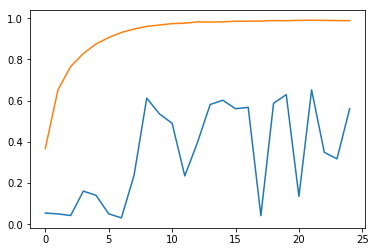

In [27]:
import seaborn as sns

sns.lineplot(x=list(range(len(h.history["val_acc"]))), y=h.history["val_acc"])
sns.lineplot(x=list(range(len(h.history["val_acc"]))), y=h.history["acc"])

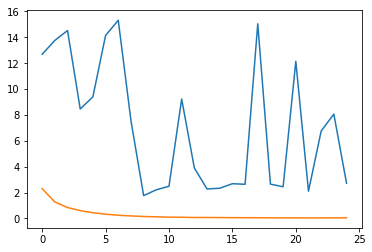

In [28]:
import seaborn as sns

sns.lineplot(x=list(range(len(h.history["val_acc"]))), y=h.history["val_loss"])
sns.lineplot(x=list(range(len(h.history["val_acc"]))), y=h.history["loss"])




In [29]:
score = model.evaluate(x_test, y_test, batch_size=128)

6835/6835 [==============================] - 42s 6ms/step


In [31]:
score


[2.7751166023123237, 0.5644476958758307]

In [ ]:
model.save("model-wav-conv-25epochs.h5")